In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import statsmodels
from statsmodels.tsa.stattools import coint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import fxcmpy
con = fxcmpy.fxcmpy(config_file = 'fxcm.cfg')

def z(df):
    return (df - df.mean()) / df.std()

In [17]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [18]:
symbols = ['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CAD', 'USD/CHF', 'AUD/USD', 'NZD/USD', 'EUR/AUD', 'EUR/CAD', 'EUR/CHF', 'EUR/GBP', 'EUR/JPY', 'EUR/NZD', 'GBP/AUD', 'GBP/CAD', 'GBP/CHF', 'GBP/JPY', 'GBP/NZD', 'AUD/CAD', 'AUD/CHF', 'AUD/JPY', 'AUD/NZD', 'NZD/CAD', 'NZD/CHF', 'NZD/JPY', 'CAD/CHF', 'CAD/JPY', 'CHF/JPY']

In [19]:
df = dict()
for symbol in symbols:
    df[symbol] = con.get_candles(symbol, period='H1', number=100) #20 Days
    #df[symbol] = con.get_candles(symbol, period='D1', number=20)
    #df[symbol] = con.get_candles(symbol, period='H4', number=110)
    df[symbol]['Close'] = (df[symbol]['bidclose'] + df[symbol]['askclose'])/2
    df[symbol]['Close_z'] = z(df[symbol]['Close'])

In [20]:
data = pd.DataFrame()
for symbol in symbols:
    data[symbol] = df[symbol]['Close']
data.dropna(inplace=True)

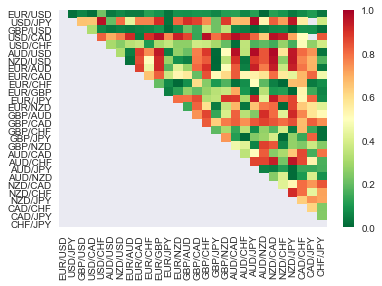

[('EUR/USD', 'USD/JPY'), ('EUR/USD', 'USD/CAD'), ('EUR/USD', 'AUD/USD'), ('EUR/USD', 'EUR/AUD'), ('EUR/USD', 'EUR/CAD'), ('EUR/USD', 'EUR/JPY'), ('EUR/USD', 'AUD/NZD'), ('EUR/USD', 'NZD/JPY'), ('EUR/USD', 'CHF/JPY'), ('USD/JPY', 'EUR/JPY'), ('GBP/USD', 'AUD/USD'), ('GBP/USD', 'EUR/AUD'), ('GBP/USD', 'EUR/JPY'), ('GBP/USD', 'AUD/CHF'), ('GBP/USD', 'AUD/JPY'), ('GBP/USD', 'AUD/NZD'), ('GBP/USD', 'NZD/JPY'), ('GBP/USD', 'CHF/JPY'), ('USD/CAD', 'EUR/CAD'), ('USD/CHF', 'AUD/CAD'), ('AUD/USD', 'EUR/AUD'), ('AUD/USD', 'GBP/JPY'), ('AUD/USD', 'CHF/JPY'), ('NZD/USD', 'EUR/AUD'), ('NZD/USD', 'GBP/JPY'), ('NZD/USD', 'AUD/CHF'), ('EUR/AUD', 'GBP/JPY'), ('EUR/AUD', 'CHF/JPY'), ('EUR/CHF', 'EUR/NZD'), ('EUR/CHF', 'AUD/CAD'), ('EUR/CHF', 'NZD/CHF'), ('EUR/CHF', 'CAD/JPY'), ('EUR/GBP', 'EUR/JPY'), ('EUR/GBP', 'AUD/JPY'), ('EUR/GBP', 'NZD/JPY'), ('EUR/NZD', 'GBP/JPY'), ('EUR/NZD', 'AUD/CHF'), ('EUR/NZD', 'NZD/CHF'), ('GBP/CHF', 'NZD/JPY'), ('GBP/CHF', 'CHF/JPY'), ('GBP/JPY', 'AUD/CHF'), ('GBP/JPY', 'NZ

In [21]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
#import seaborn
#m = [0,0.2,0.4,0.6,0.8,1]
sns.heatmap(pvalues, xticklabels=symbols, 
                yticklabels=symbols, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print (pairs)

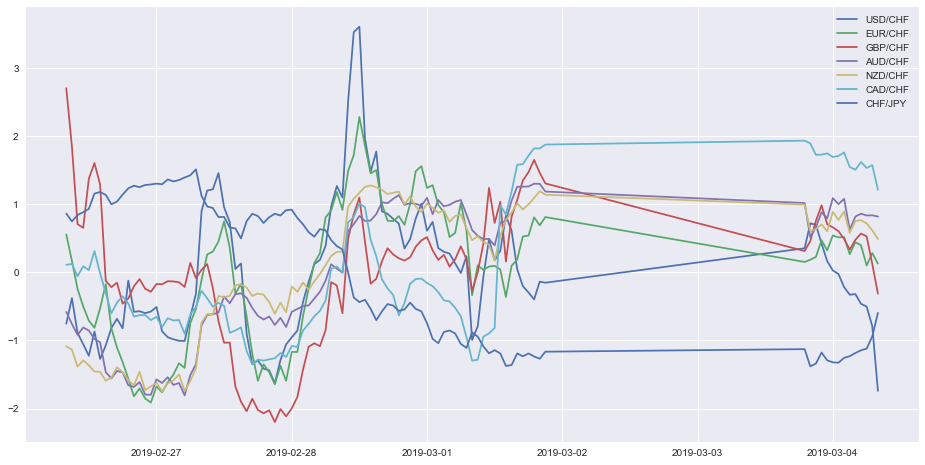

In [28]:
s_split = 'CHF'
plt.figure(figsize=(16,8))
for symbol in symbols:
    #if df[symbol].iloc[-1]['Close_z'] >  2 or df[symbol].iloc[-1]['Close_z'] < -2 or True:
    tmp_split = symbol.split('/')
    if (tmp_split[0] == s_split or tmp_split[1] == s_split):
        if tmp_split[1] == s_split:
            df[symbol]['Close_z'] *= -1
        plt.plot(df[symbol]['Close_z'], label=symbol)
plt.legend()

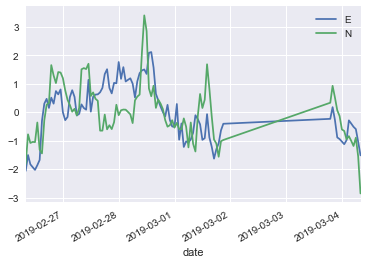

In [27]:
df['AUD/NZD']['Close_z'].plot(label='E')
df['EUR/USD']['Close_z'].plot(label='N')
plt.legend()
plt.show()

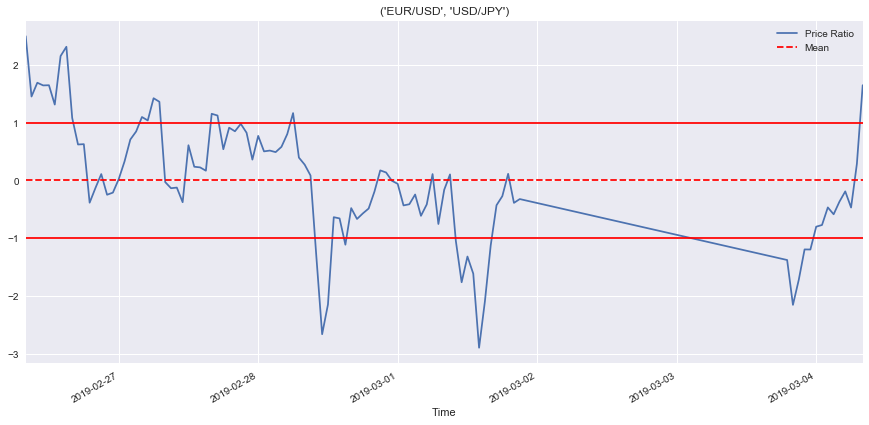

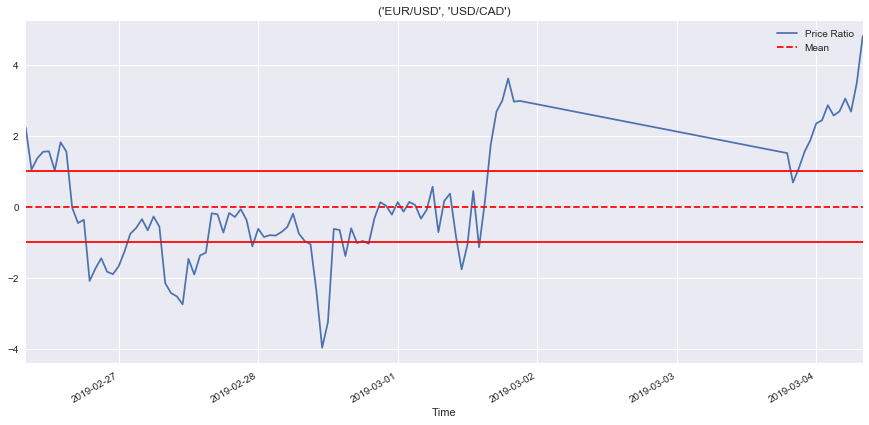

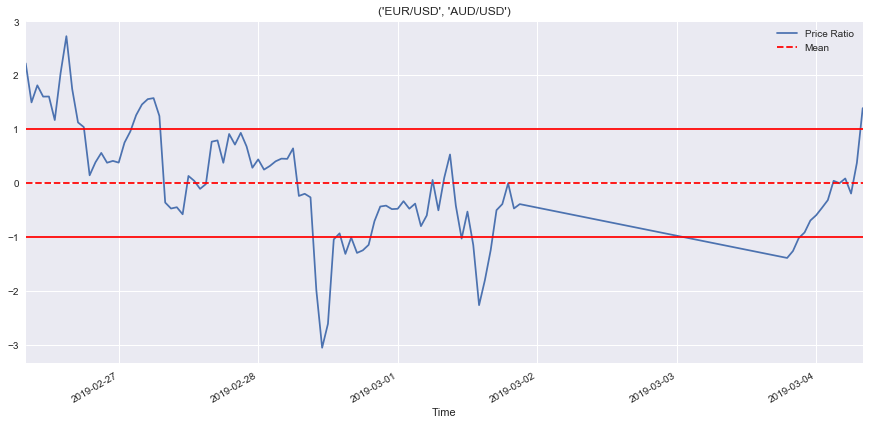

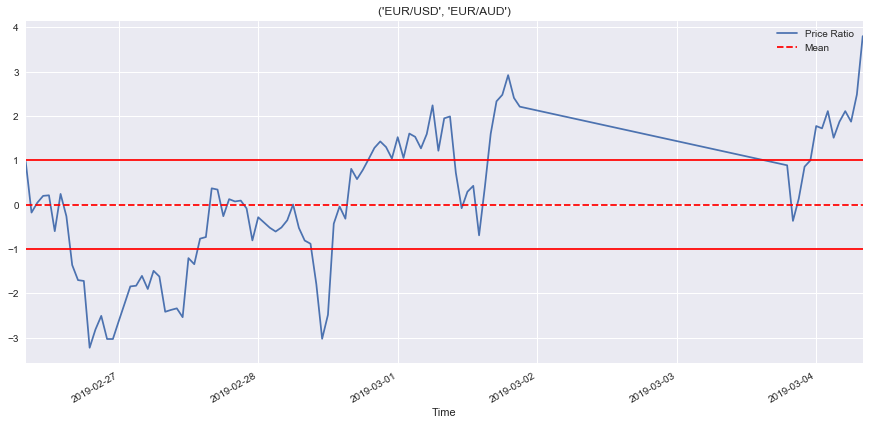

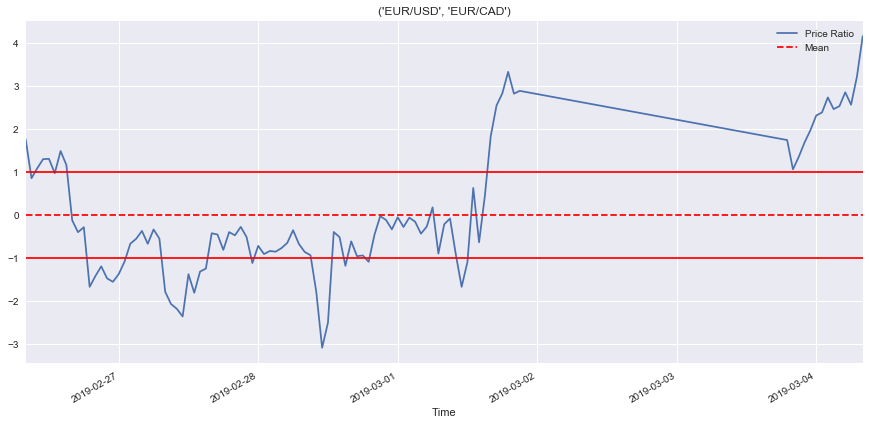

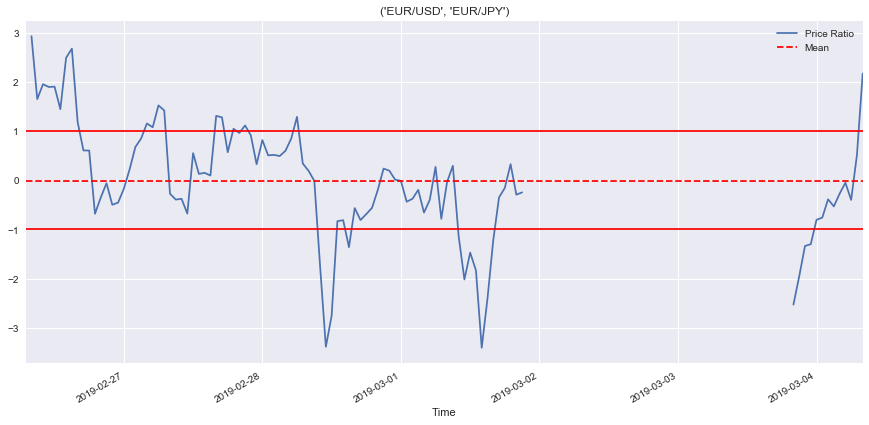

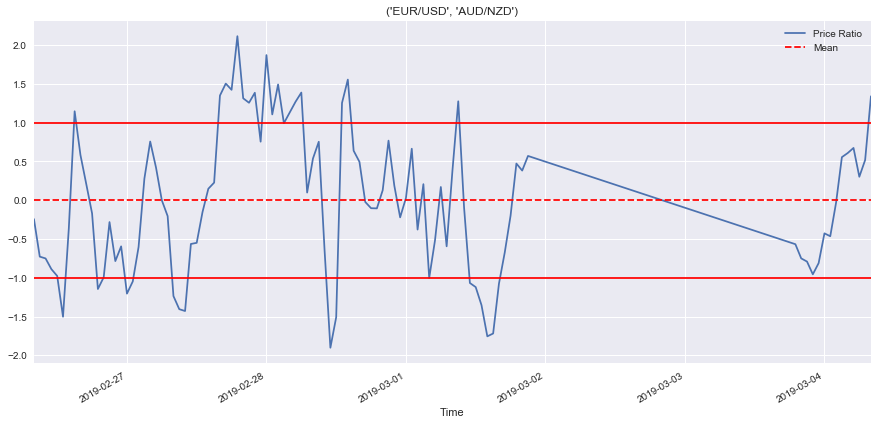

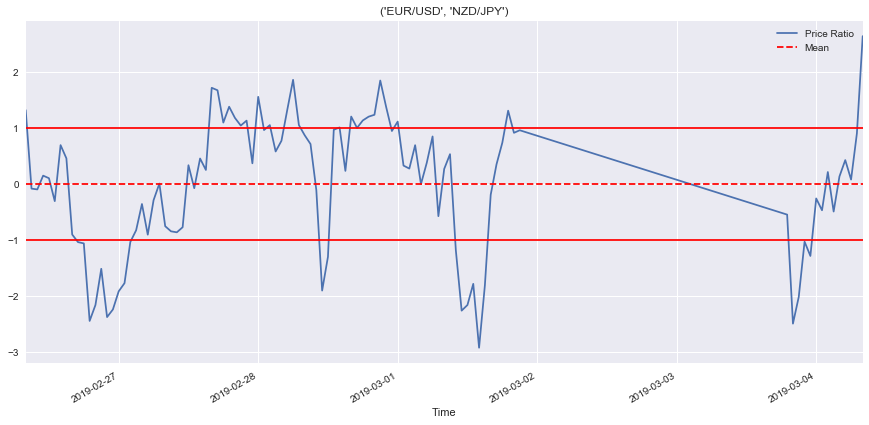

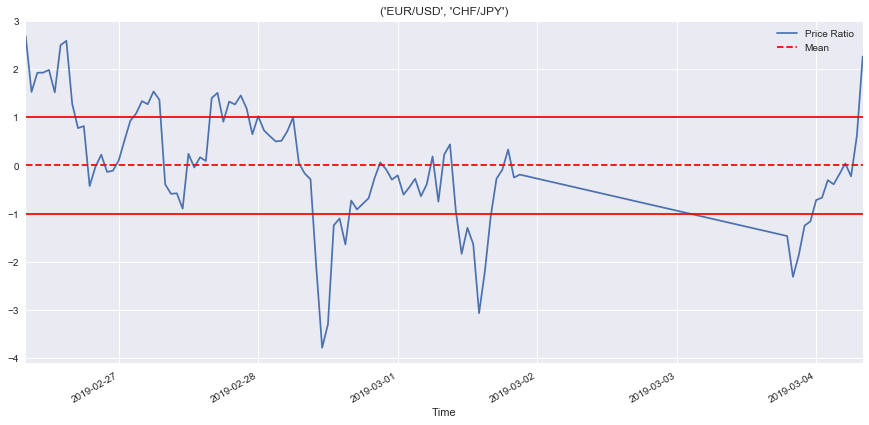

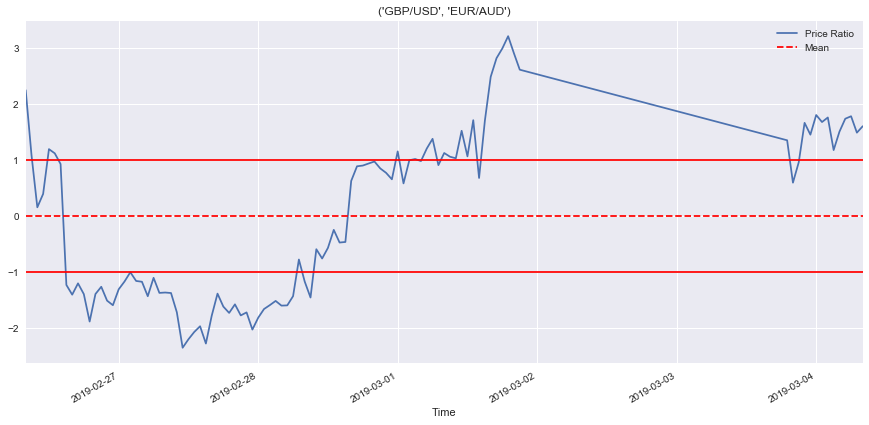

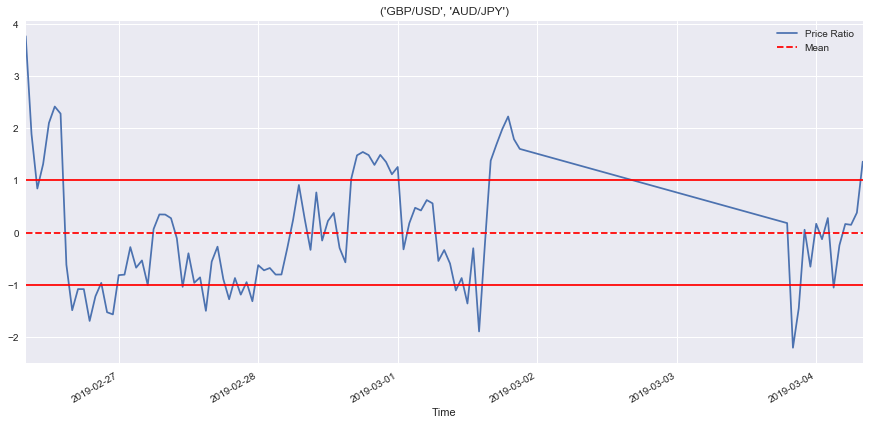

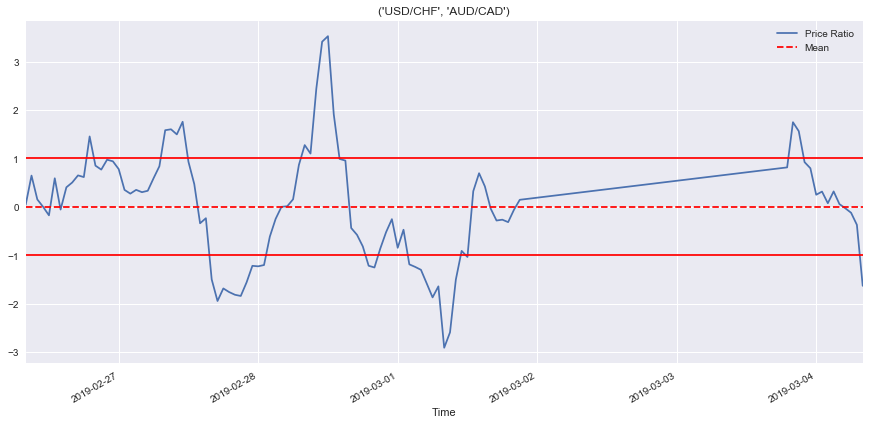

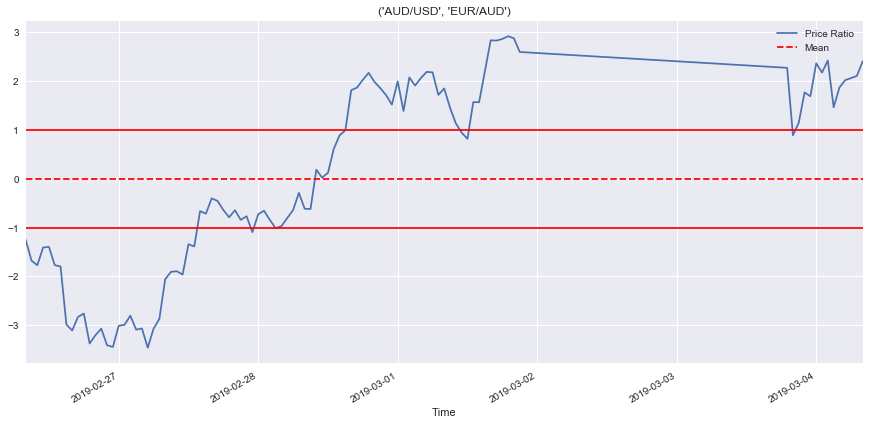

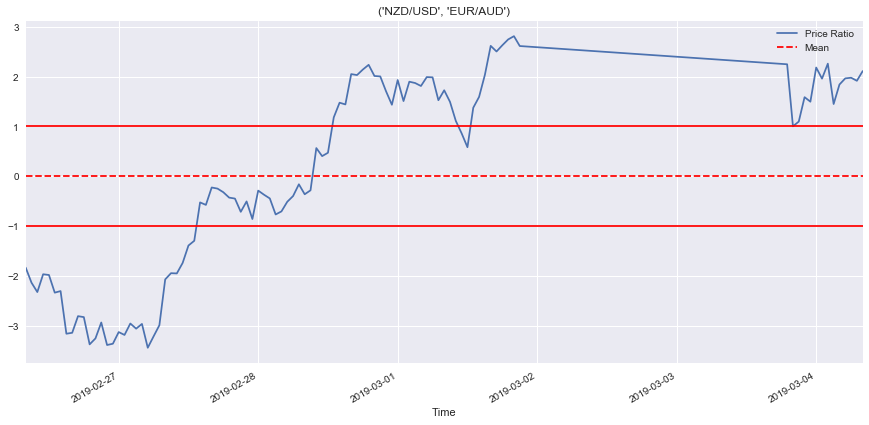

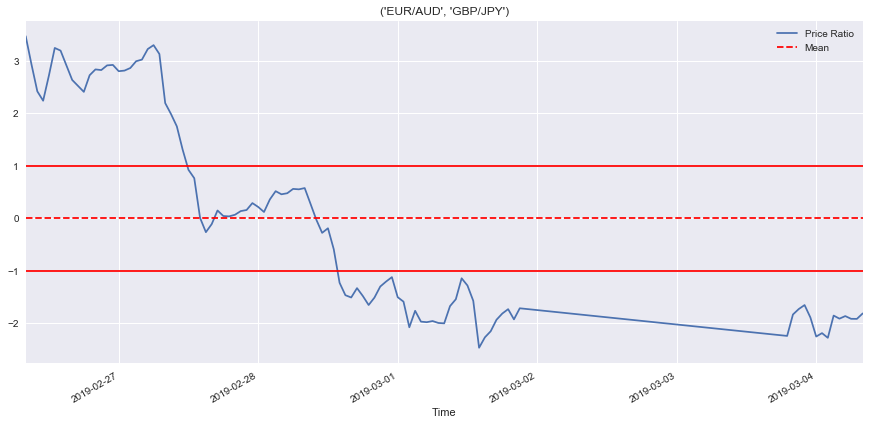

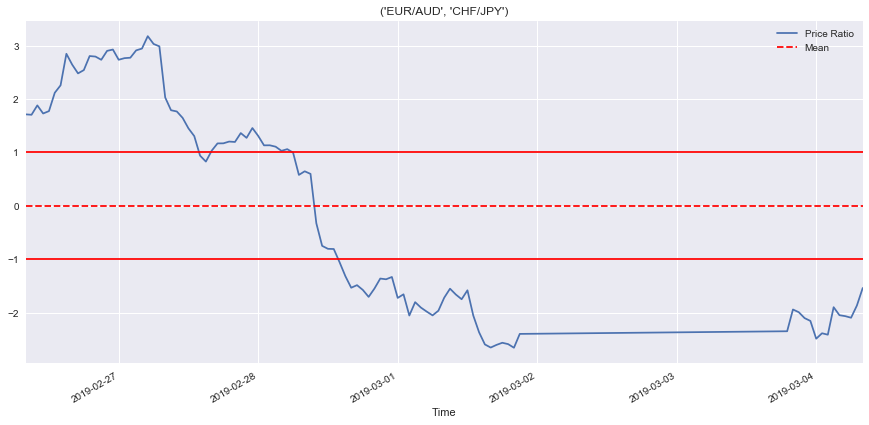

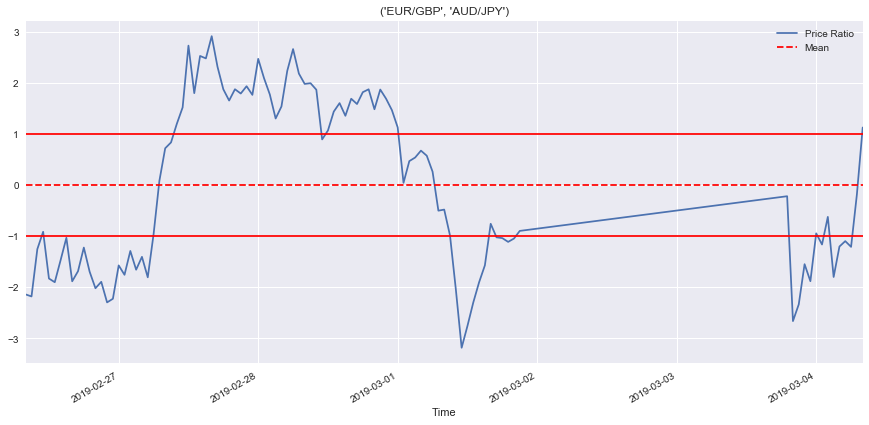

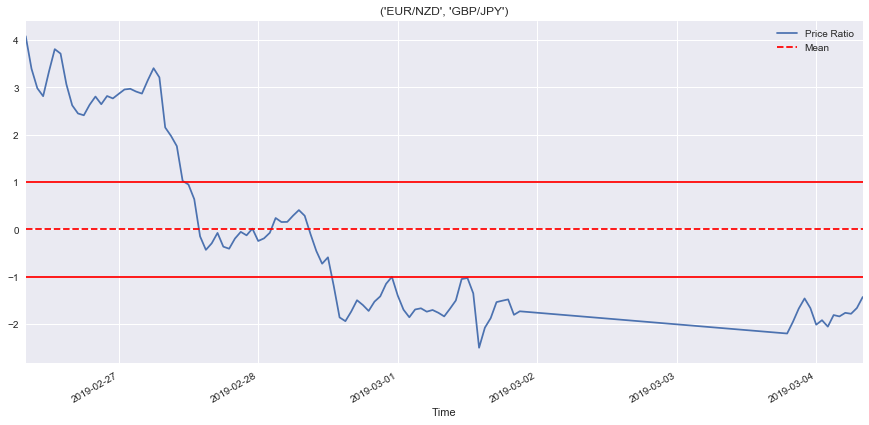

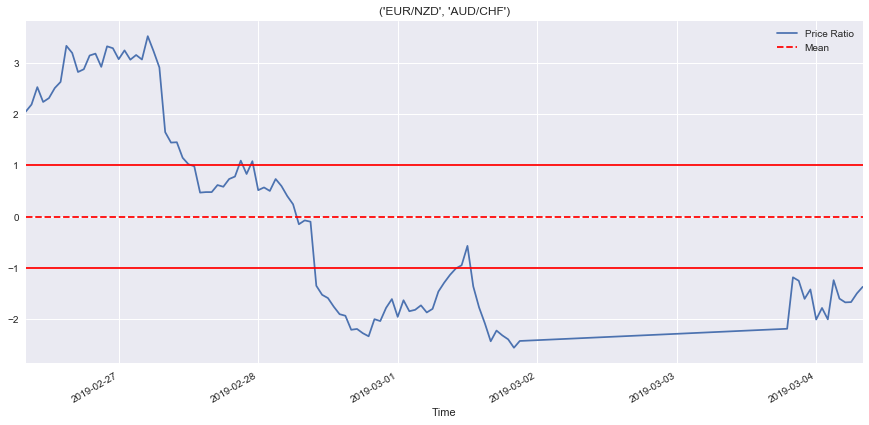

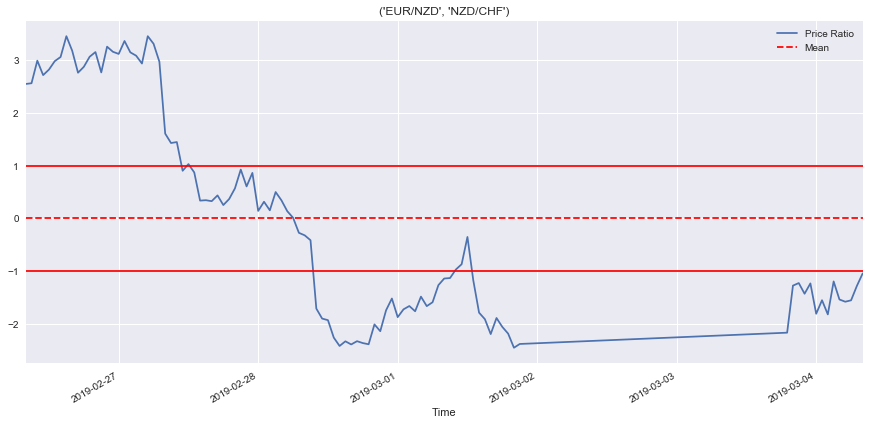

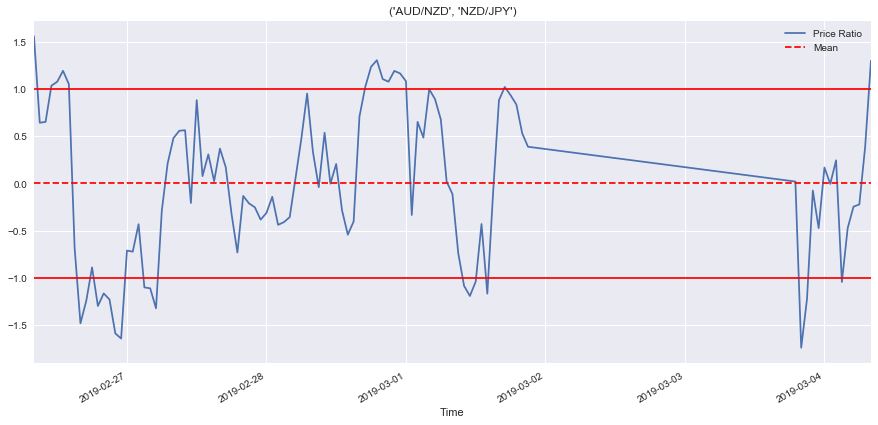

In [25]:
s = 'USD/CHF'
all_symbol = True
length = len(pairs)
for i in range(length):
    if (pairs[i][1] == s or pairs[i][0] == s or all_symbol):
        diff = df[pairs[i][1]]['Close_z'] - df[pairs[i][0]]['Close_z']
        if (diff.iloc[-1] > 1 or diff.iloc[-1] < -1):
            plt.title(pairs[i])
            (diff).plot(figsize=(15,7))
            plt.axhline(np.mean(diff), color='red', linestyle='--')
            plt.axhline(y=1, color='red')
            plt.axhline(y=-1, color='red')
            plt.xlabel('Time')
            plt.legend(['Price Ratio', 'Mean'])
            plt.show()